# **Detección de Fraude**

**Realizado por:** 

Maricela Carmona Mora.
Correo: maricela.carmona@udea.edu.co

Leidy Marcela Londoño Morales.
Correo: leidy.londonom@udea.edu.co

# **Objetivos:**

**Negocio:**

- Identificar posibles transacciones fraudulentas realizadas a través del sistema de billetera móvil.
- Generar alertas en el monto y número de transacciones que sean sospechosas de fraude.

**Analítica de datos:**
- Realizar un modelo analítico que tenga un buen ajuste (buena precisión) a la hora de detectar transacciones fraudulentas realizadas a través del sistema de billetera móvil, cuyo costo operacional y tiempo de identificación sea mínimo.


# **Fuente de datos:**

- Datos tomados de Kaggle, los cuales son el producto de una simulación de transacciones de dinero móvil, basadas en una muestra de transacciones reales extraídas de un mes de registros financieros, implementado en un país africano. Los registros originales fueron proporcionados por una empresa multinacional, proveedor del servicio financiero móvil.
- Se trabajará con 6 millones de transacciones aproximadamente.
https://www.kaggle.com/ntnu-testimon/paysim1


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer, confusion_matrix, classification_report
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os

In [ ]:
! pip install -q kaggle

**Nota: Antes de ejecutar la siguiente linea, ingresar a Kaggle con usuario y contraseña. En el perfil ingresar a la opción: account, crear un nuevo api token, el cual descargará un archivo .json, necesario para la siguiente conexión y descarga de los datos** 

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leidylondoo","key":"ec5f5de4ed8248e02b72dccf44ecbb67"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-21 06:23:33           5819  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3227  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1150  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1887  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
! kaggle datasets download -d ntnu-testimon/paysim1

 92% 163M/178M [00:01<00:00, 116MB/s]
100% 178M/178M [00:01<00:00, 119MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip paysim1.zip -d train

Archive:  paysim1.zip
  inflating: train/PS_20174392719_1491204439457_log.csv  


In [ ]:
cd train

/content/train


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Datos Originales**

In [ ]:
datos = pd.read_csv("PS_20174392719_1491204439457_log.csv")
datos.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


- step: Asigna una unidad de tiempo en el mundo real. Representa la hora y fecha en la que se realizó la transacción
- type: Cash-in, Cash-out, debito, pago, transferencia
- amount: Monto de la transacción
- nameOrig: Cliente que inició la transacción
- oldbalanceOrg: Saldo inicial del remitente antes de la transacción
- newbalanceOrig: Nuevo saldo del remitente después de la transacción
- nameDest: Cliente destinatario de la transacción
- oldbalanceDest: Saldo inicial del destinatario antes de la transacción
- newbalanceDest: Nuevo saldo del destinatario después de la transacción
- isFlaggedFraud: Intentos ilegales. Un intento ilegal en este conjunto de datos es un intento de transferir más de 200.000 en una sola transacción
- isFraud: Variable respuesta, donde 1 representa una transacción fraudulenta


In [ ]:
datos.isnull().values.any()

False

In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


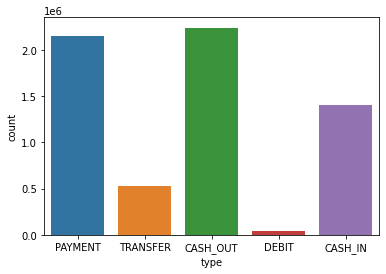

In [ ]:
sns.countplot(datos.type)

In [ ]:
datos[["type",
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    'isFraud']].groupby(["type","isFraud"]).agg(['count','mean'])

amount                ... newbalanceDest              
                    count          mean  ...          count          mean
type     isFraud                         ...                             
CASH_IN  0        1399284  1.689202e+05  ...        1399284  1.467105e+06
CASH_OUT 0        2233384  1.739172e+05  ...        2233384  1.689744e+06
         1           4116  1.455103e+06  ...           4116  2.549545e+06
DEBIT    0          41432  5.483665e+03  ...          41432  1.513003e+06
PAYMENT  0        2151495  1.305760e+04  ...        2151495  0.000000e+00
TRANSFER 0         528812  9.062290e+05  ...         528812  3.582075e+06
         1           4097  1.480892e+06  ...           4097  3.981411e+03

[7 rows x 10 columns]

**El número de TRANSFERENCIAS fraudulentas casi iguala al número de CASH_OUT fraudulentos**

In [ ]:
print('\n El tipo de transacciones fraudulentas son {}'.format(\
list(datos.loc[datos.isFraud == 1].type.drop_duplicates().values))) # solo 'CASH_OUT' # & 'TRANSFER'

dfFraudTransfer = datos.loc[(datos.isFraud == 1) & (datos.type == 'TRANSFER')]
dfFraudCashout = datos.loc[(datos.isFraud == 1) & (datos.type == 'CASH_OUT')]

print ('\n El número de TRANSFER fraudulentas = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n El número de CASH_OUTs fraudulentas = {}'.\
       format(len(dfFraudCashout))) # 4116


 El tipo de transacciones fraudulentas son ['TRANSFER', 'CASH_OUT']

 El número de TRANSFER fraudulentas = 4097

 El número de CASH_OUTs fraudulentas = 4116


In [ ]:
print('\nEl tipo de transacciones en las que se establece isFlaggedFraud es: \
{}'.format(list(datos.loc[datos.isFlaggedFraud == 1].type.drop_duplicates()))) # solo 'TRANSFER'

dfTransfer = datos.loc[datos.type == 'TRANSFER']
dfFlagged = datos.loc[datos.isFlaggedFraud == 1]
dfNotFlagged = datos.loc[datos.isFlaggedFraud == 0]

print('\nCantidad mínima transada con isFlaggedFraud establecido= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nCantidad maxima transferida cuando isFlaggedFraud no está establecido=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 924


El tipo de transacciones en las que se establece isFlaggedFraud es: ['TRANSFER']

Cantidad mínima transada con isFlaggedFraud establecido= 353874.22

Cantidad maxima transferida cuando isFlaggedFraud no está establecido= 92445516.64


In [ ]:
print('Hay comerciantes entre las cuentas originales de la transacciones CASH_IN? {}'.format(\
(datos.loc[datos.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) 

Hay comerciantes entre las cuentas originales de la transacciones CASH_IN? False


In [ ]:
print('Hay comerciantes entre las cuentas originales de la transacciones CASH_OUT? {}'.format(\
(datos.loc[datos.type == 'CASH_OUT'].nameOrig.str.contains('M')).any())) 

Hay comerciantes entre las cuentas originales de la transacciones CASH_OUT? False


In [ ]:
cash = datos[(datos.type =="CASH_OUT") | (datos.type  =="CASH_IN")]
cash.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0
48,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0


In [ ]:
cash1 = cash[cash['nameOrig'].str.contains('C')]
cash1.count()

step              3636784
type              3636784
amount            3636784
nameOrig          3636784
oldbalanceOrg     3636784
newbalanceOrig    3636784
nameDest          3636784
oldbalanceDest    3636784
newbalanceDest    3636784
isFraud           3636784
isFlaggedFraud    3636784
dtype: int64

In [ ]:
cash2 = datos.loc[datos.type == 'CASH_IN'].nameOrig.str.get(0)
print(cash2)

389        C
390        C
391        C
392        C
393        C
          ..
6362253    C
6362271    C
6362279    C
6362298    C
6362315    C
Name: nameOrig, Length: 1399284, dtype: object


In [ ]:
cash.shape

(3636784, 11)

**Histograma de la variable objetivo tomando los datos originales**

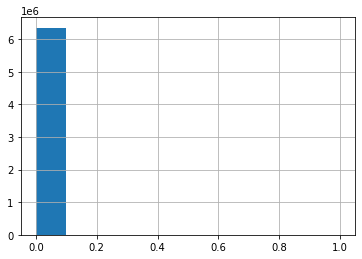

In [ ]:
datos['isFraud'].hist()

In [ ]:
datos["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

**Teniendo en cuenta el análisis anterior, solo se tendrá en cuenta los tipos de transacciones: TRANSFER y CASH_OUT**

In [ ]:
X = datos.loc[(datos.type == 'TRANSFER') | (datos.type == 'CASH_OUT')]

**Eliminamos las variables que consideramos que son menos significativas**

In [ ]:
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

In [ ]:
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) 

In [ ]:
X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,0,181.00,181.00,0.0,0.00,0.00,1
3,1,1,181.00,181.00,0.0,21182.00,0.00,1
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44,0
19,1,0,215310.30,705.00,0.0,22425.00,0.00,0
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13,1
6362616,743,0,6311409.28,6311409.28,0.0,0.00,0.00,1
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,743,0,850002.52,850002.52,0.0,0.00,0.00,1


**Verificamos que ninguna variable tenga desviación estándar cero:**

In [ ]:
X.std(axis=0)

step              1.416191e+02
type              3.941525e-01
amount            8.877897e+05
oldbalanceOrg     2.513251e+05
newbalanceOrig    1.512558e+05
oldbalanceDest    4.225550e+06
newbalanceDest    4.676990e+06
isFraud           5.436687e-02
dtype: float64

**Histograma de la variable objetivo tomando los datos finales**

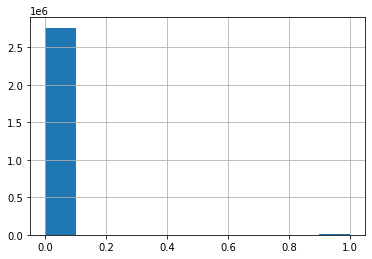

In [ ]:
X['isFraud'].hist()

In [ ]:
X["isFraud"].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

**Matriz de correlación**

In [ ]:
X.corr()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,-0.016022,0.037007,0.005744,-0.011280,0.037778,0.037475,0.048671
type,-0.016022,1.000000,-0.326040,-0.013202,0.018726,-0.099794,-0.157024,-0.042400
amount,0.037007,-0.326040,1.000000,0.120389,0.018296,0.307133,0.497027,0.070660
oldbalanceOrg,0.005744,-0.013202,0.120389,1.000000,0.778826,-0.020403,-0.010029,0.347582
newbalanceOrig,-0.011280,0.018726,0.018296,0.778826,1.000000,-0.012277,-0.015439,0.063557
oldbalanceDest,0.037778,-0.099794,0.307133,-0.020403,-0.012277,1.000000,0.970060,-0.014960
newbalanceDest,0.037475,-0.157024,0.497027,-0.010029,-0.015439,0.970060,1.000000,-0.008978
isFraud,0.048671,-0.042400,0.070660,0.347582,0.063557,-0.014960,-0.008978,1.000000


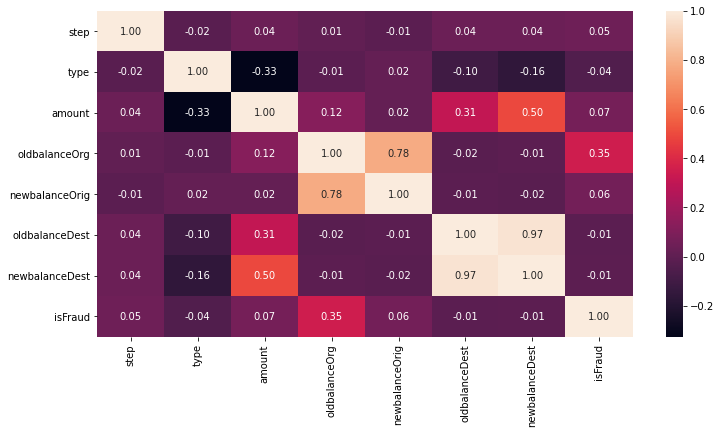

In [ ]:
# Explore correlations visually
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(X.corr(), annot=True, fmt='.2f')

Cambiar el tipo de datos

In [ ]:
X['Hour'] = X['step'] % 24

X['Hour'] = X['Hour'].astype('object')

Número de transacciones por hora



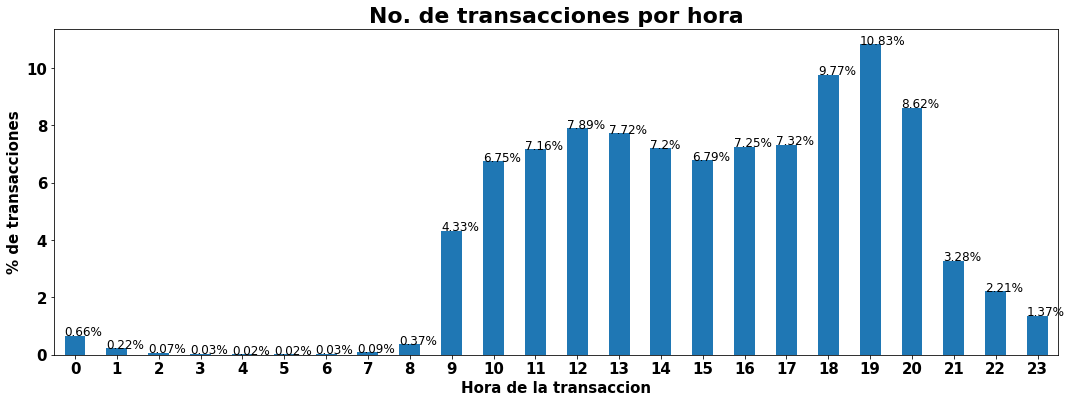

In [ ]:
plt.figure(figsize=(18,6))
ax = (X['Hour'].value_counts(sort=False, normalize=True) * 100).round(2).plot(kind='bar')
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)) + "%", fontsize=12, color='black')
plt.xlabel('Hora de la transaccion', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% de transacciones', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. de transacciones por hora', fontsize=22, fontweight='bold')
plt.show()

In [ ]:
X_fraude = X.loc[X.isFraud == 1]
X_fraude.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Hour
2,1,0,181.0,181.0,0.0,0.0,0.0,1,1
3,1,1,181.0,181.0,0.0,21182.0,0.0,1,1
251,1,0,2806.0,2806.0,0.0,0.0,0.0,1,1
252,1,1,2806.0,2806.0,0.0,26202.0,0.0,1,1
680,1,0,20128.0,20128.0,0.0,0.0,0.0,1,1


Número de transacciones fraudulentas por hora

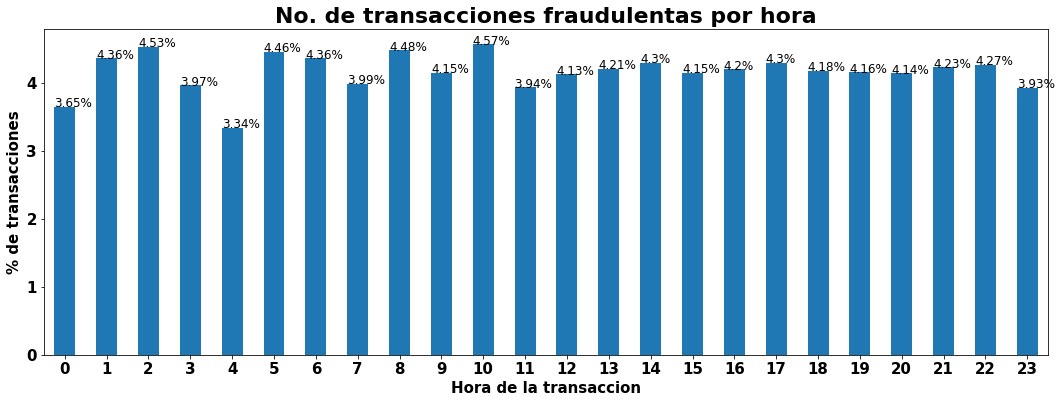

In [ ]:
plt.figure(figsize=(18,6))
ax = (X_fraude['Hour'].value_counts(sort=False, normalize=True) * 100).round(2).plot(kind='bar')
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)) + "%", fontsize=12, color='black')
plt.xlabel('Hora de la transaccion', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% de transacciones', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. de transacciones fraudulentas por hora', fontsize=22, fontweight='bold')
plt.show()

**Dispersión sobre la variable: oldbalanceOrg por tipo de transacción, TRANSFER = 0, CASH_OUT = 1**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


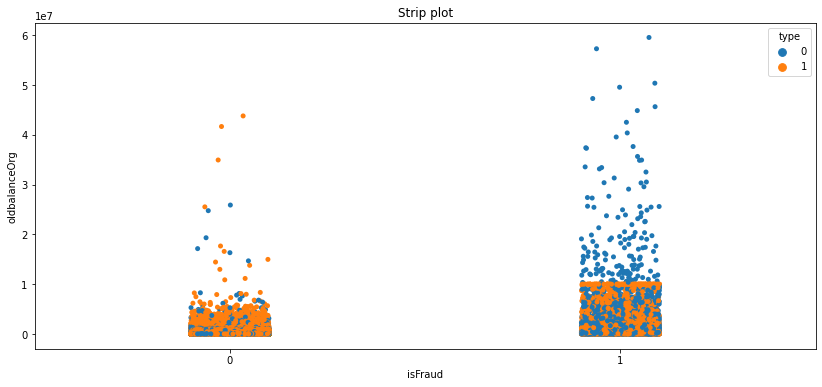

In [ ]:
fig, ax= plt.subplots(figsize=(14, 6))  
sns.stripplot(X['isFraud'], X['oldbalanceOrg'],X['type'], jitter=True, ax=ax)  
ax.set_title('Strip plot')  
plt.show() 

**Dispersión sobre la variable: amount por tipo de transacción, TRANSFER = 0, CASH_OUT = 1**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


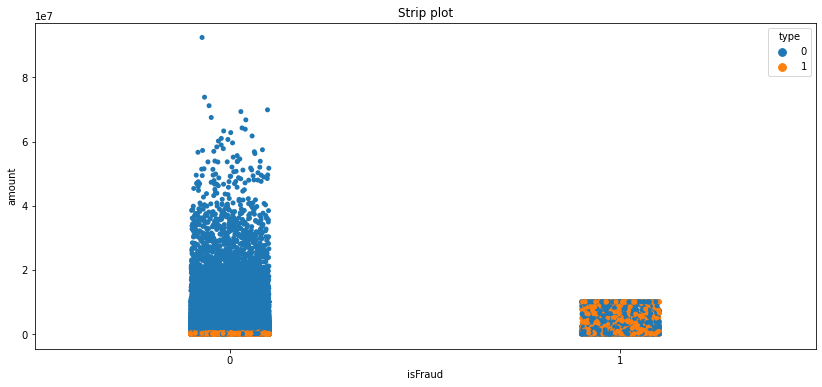

In [ ]:
fig, ax= plt.subplots(figsize=(14, 6))  
sns.stripplot(X['isFraud'], X['amount'],X['type'], jitter=True, ax=ax)  
ax.set_title('Strip plot')  
plt.show() 

**Dispersión sobre la variable: oldbalanceDest por tipo de transacción, TRANSFER = 0, CASH_OUT = 1**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


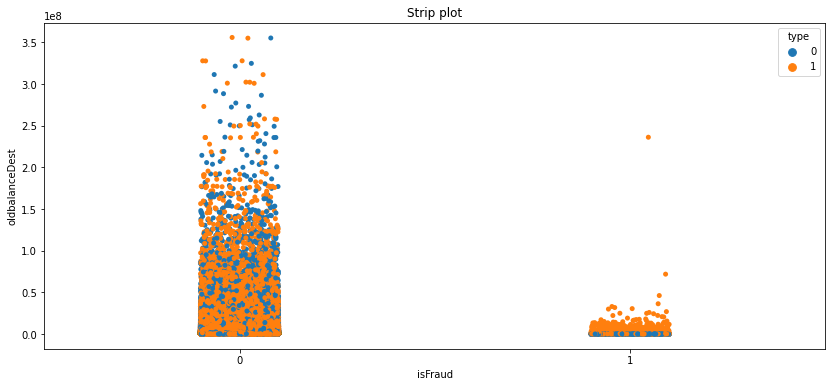

In [ ]:
fig, ax= plt.subplots(figsize=(14, 6))  
sns.stripplot(X['isFraud'], X['oldbalanceDest'],X['type'], jitter=True, ax=ax)  
ax.set_title('Strip plot')  
plt.show() 

**Dispersión sobre la variable: newbalanceDest por tipo de transacción, TRANSFER = 0, CASH_OUT = 1**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


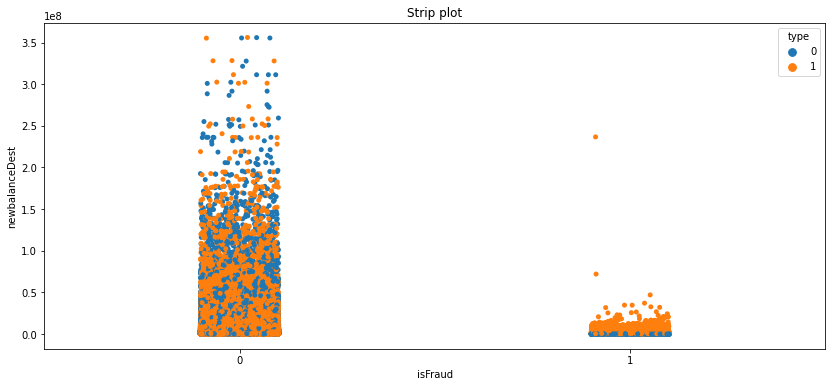

In [ ]:
fig, ax= plt.subplots(figsize=(14, 6))  
sns.stripplot(X['isFraud'], X['newbalanceDest'],X['type'], jitter=True, ax=ax)  
ax.set_title('Strip plot')  
plt.show() 

In [ ]:
X = X.drop(['step'], axis= 1) 
X.head(3)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Hour
2,0,181.00,181.0,0.0,0.0,0.00,1,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,1
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,1


# **Aplicación de modelos**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.drop(['isFraud'], axis = 1), X['isFraud'],
                                                    random_state=0, test_size=0.3, stratify=X['isFraud'])

In [ ]:
skf = StratifiedKFold(n_splits=3)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)

**Modelo 1: LogisticRegression**

In [ ]:
clf = LogisticRegression(class_weight='balanced')
grid_values = {'penalty': ['l2'],'C':[0.001,0.01,0.8]}
grid_clf = GridSearchCV(clf, param_grid = grid_values, cv=skf, scoring = 'recall')

In [ ]:
grid_clf.fit(X_train_n, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.8], 'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [ ]:
model = grid_clf.best_estimator_
model

LogisticRegression(C=0.8, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
scores = cross_val_score(model, X_train_n, y_train, cv=skf, scoring="accuracy")
scores

array([0.9413996 , 0.9399996 , 0.94178315])

In [ ]:
scores1 = cross_val_score(model, X_train_n, y_train, cv=skf, scoring="recall")
scores1

array([0.90553236, 0.90871153, 0.90292276])

In [ ]:
 pred = model.predict(X_test_n)
 print(confusion_matrix(y_test, pred))

[[782064  46595]
 [   263   2201]]


Accuracy test búsqueda = 0.9436208599689817


Text(0.5, 1.0, 'Búsqueda')

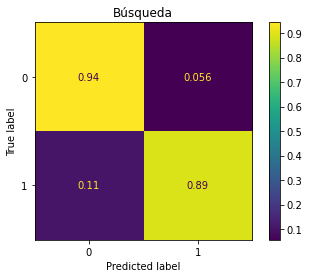

In [ ]:
print('Accuracy test búsqueda = '+str(accuracy_score(y_test,model.predict(X_test_n))))

disp = plot_confusion_matrix(model,X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

Balanced Accuracy test búsqueda = 0.9185167925257524


Text(0.5, 1.0, 'Búsqueda')

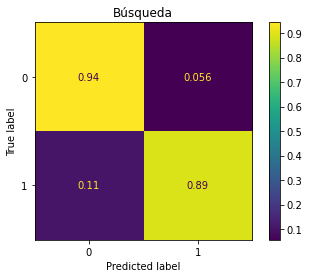

In [ ]:
print('Balanced Accuracy test búsqueda = '+str(balanced_accuracy_score(y_test,model.predict(X_test_n))))

disp = plot_confusion_matrix(model,X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    828659
           1       0.05      0.89      0.09      2464

    accuracy                           0.94    831123
   macro avg       0.52      0.92      0.53    831123
weighted avg       1.00      0.94      0.97    831123



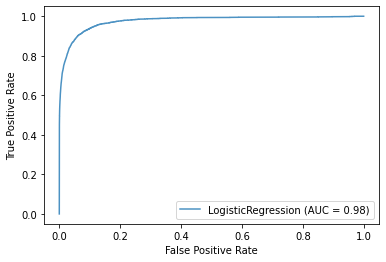

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(model, X_test_n, y_test, ax=ax, alpha=0.8)
plt.show()

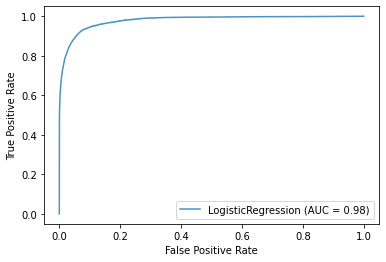

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(model, X_train_n, y_train, ax=ax, alpha=0.8)
plt.show()

In [ ]:
f1_score(y_test, pred, average=None)

array([0.97091347, 0.08587593])

**Modelo 2: RandomForestClassifier**

In [ ]:
st = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

In [ ]:
B=[5, 10, 15]
grid_values1 = {'n_estimators': B, 'max_depth':[3, 4]}

clf1 = RandomForestClassifier(random_state=0, class_weight='balanced_subsample', n_jobs=-1)
grid_clf1 = GridSearchCV(estimator=clf1, param_grid = grid_values1, cv=st, scoring='balanced_accuracy',return_train_score=True)
grid_clf1.fit(X_train_n, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_job

In [ ]:
model1 = grid_clf1.best_estimator_
model1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=15, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [ ]:
 pred1 = model1.predict(X_test_n)
 print(confusion_matrix(y_test, pred1))

[[822888   5771]
 [  1315   1149]]


In [ ]:
scores2 = cross_val_score(model1, X_train_n, y_train, cv=skf, scoring="accuracy")
scores2

array([0.96898345, 0.9803536 , 0.96899732])

In [ ]:
scores3 = cross_val_score(model1, X_train_n, y_train, cv=skf, scoring="recall")
scores3

array([0.92118998, 0.92227439, 0.92954071])

Accuracy test búsqueda = 0.9914741861312947


Text(0.5, 1.0, 'Búsqueda')

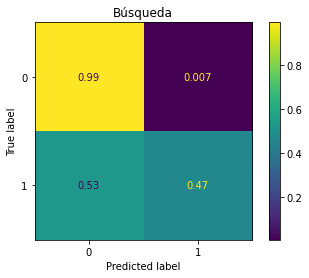

In [ ]:
print('Accuracy test búsqueda = '+str(accuracy_score(y_test, model1.predict(X_test_n))))

disp = plot_confusion_matrix(model1, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

Balanced Accuracy test búsqueda = 0.7296753355577952


Text(0.5, 1.0, 'Búsqueda')

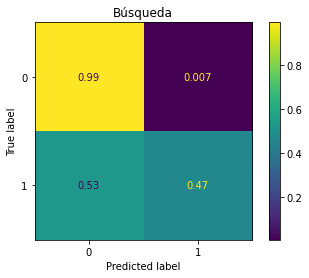

In [ ]:
print('Balanced Accuracy test búsqueda = '+str(balanced_accuracy_score(y_test, model1.predict(X_test_n))))

disp = plot_confusion_matrix(model1, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

In [ ]:
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    828659
           1       0.16      0.60      0.25      2464

    accuracy                           0.99    831123
   macro avg       0.58      0.80      0.62    831123
weighted avg       1.00      0.99      0.99    831123



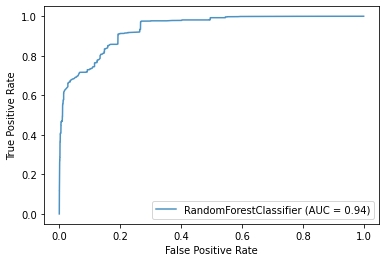

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(model1, X_test_n, y_test, ax=ax, alpha=0.8)
plt.show()

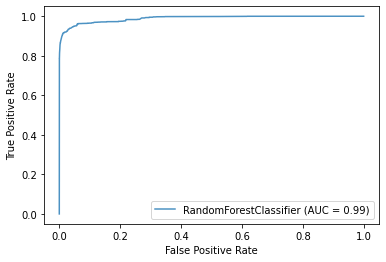

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(model1, X_train_n, y_train, ax=ax, alpha=0.8)
plt.show()

**Modelo 3: NaiveBayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB

grid_values2 = {'var_smoothing': [1e-2, 1e-4, 1e-6, 1e-10, 1e-15]}

In [ ]:
grid_clf2 = GridSearchCV(GaussianNB(), cv=skf, param_grid=grid_values2)
grid_clf2.fit(X_train_n, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': [0.01, 0.0001, 1e-06, 1e-10, 1e-15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
model2 = grid_clf2.best_estimator_
model2

GaussianNB(priors=None, var_smoothing=0.01)

In [ ]:
 pred2 = model2.predict(X_test_n)
 print(confusion_matrix(y_test, pred2))

[[818818   9841]
 [  1475    989]]


In [ ]:
scores5 = cross_val_score(model2, X_train_n, y_train, cv=skf, scoring="accuracy")
scores5

array([0.98603095, 0.98553747, 0.98662032])

In [ ]:
scores6 = cross_val_score(model2, X_train_n, y_train, cv=skf, scoring="recall")
scores6

array([0.41544885, 0.42514345, 0.4065762 ])

Accuracy test búsqueda = 0.9863846867431174


Text(0.5, 1.0, 'Búsqueda')

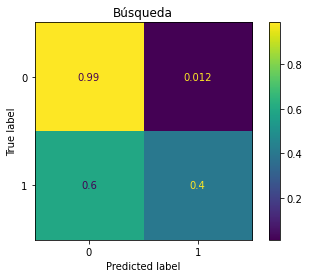

In [ ]:
print('Accuracy test búsqueda = '+str(accuracy_score(y_test,model2.predict(X_test_n))))

disp = plot_confusion_matrix(model2, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

Balanced Accuracy test búsqueda = 0.6947520281575099


Text(0.5, 1.0, 'Búsqueda')

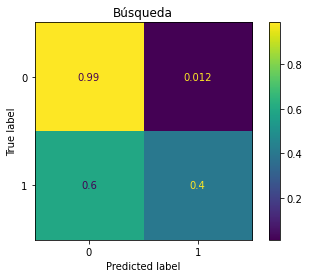

In [ ]:
print('Balanced Accuracy test búsqueda = '+str(balanced_accuracy_score(y_test,model2.predict(X_test_n))))

disp = plot_confusion_matrix(model2, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

In [ ]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    828659
           1       0.09      0.40      0.15      2464

    accuracy                           0.99    831123
   macro avg       0.54      0.69      0.57    831123
weighted avg       1.00      0.99      0.99    831123



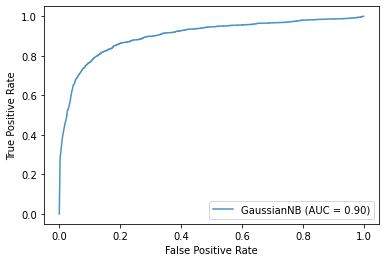

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(model2, X_test_n, y_test, ax=ax, alpha=0.8)
plt.show()

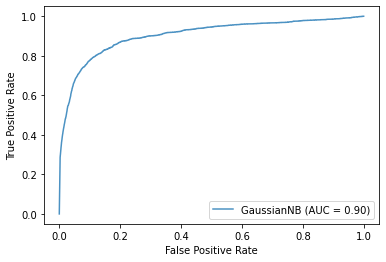

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(model2, X_train_n, y_train, ax=ax, alpha=0.8)
plt.show()

**Modelo 4: Red Neuronal**

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import tensorflow as tf
keras.backend.clear_session()

modelA= keras.models.Sequential()
modelA.add(keras.layers.Dense(25, input_dim=X_train_n.shape[1], activation='relu', kernel_initializer='he_uniform'))
modelA.add(keras.layers.Dropout(0.4))
modelA.add(keras.layers.Dense(10, input_dim=X_train_n.shape[1], activation='relu', kernel_initializer='he_uniform'))
modelA.add(keras.layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
modelA.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=[tf.keras.metrics.AUC(curve='ROC')])


In [ ]:
history = modelA.fit(X_train_n, y_train, validation_data=(scaler.fit_transform(X_test), y_test), epochs=10)

Epoch 1/10
60603/60603 [==============================] - 102s 2ms/step - loss: 0.0145 - auc: 0.8647 - val_loss: 0.0073 - val_auc: 0.9428
Epoch 2/10
60603/60603 [==============================] - 102s 2ms/step - loss: 0.0076 - auc: 0.9309 - val_loss: 0.0062 - val_auc: 0.9519
Epoch 3/10
60603/60603 [==============================] - 102s 2ms/step - loss: 0.0067 - auc: 0.9451 - val_loss: 0.0057 - val_auc: 0.9467
Epoch 4/10
60603/60603 [==============================] - 106s 2ms/step - loss: 0.0062 - auc: 0.9484 - val_loss: 0.0054 - val_auc: 0.9621
Epoch 5/10
60603/60603 [==============================] - 102s 2ms/step - loss: 0.0060 - auc: 0.9515 - val_loss: 0.0051 - val_auc: 0.9571
Epoch 6/10
60603/60603 [==============================] - 102s 2ms/step - loss: 0.0058 - auc: 0.9518 - val_loss: 0.0052 - val_auc: 0.9585
Epoch 7/10
60603/60603 [==============================] - 101s 2ms/step - loss: 0.0062 - auc: 0.9577 - val_loss: 0.0051 - val_auc: 0.9536
Epoch 8/10
60603/60603 [==========

In [ ]:
from sklearn.metrics import confusion_matrix
pred3=modelA.predict_classes(scaler.fit_transform(X_test_n))
Cm = confusion_matrix(y_test,pred3)
Cm

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[828621,     38],
       [  1042,   1422]])

In [ ]:
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.97      0.58      0.72      2464

    accuracy                           1.00    831123
   macro avg       0.99      0.79      0.86    831123
weighted avg       1.00      1.00      1.00    831123



Evaluamos el modelo

Train: 0.972, Test: 0.961


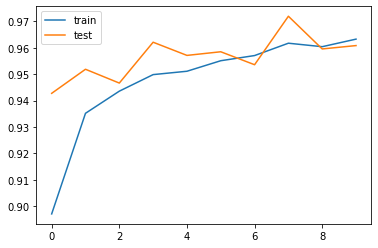

In [ ]:
_, train_acc = modelA.evaluate(X_train_n, y_train, verbose=0)
_, test_acc = modelA.evaluate(scaler.fit_transform(X_test_n), y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.legend()
plt.show()

**Aplicación de la técnica de SMOTE (Datos sintéticos)**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek, ADASYN 

from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train_n, y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from collections import Counter
print("Antes de SMOTE: ", Counter(y_train))
print("Despues de SMOTE: ", Counter(y_train_SMOTE))

Antes de SMOTE:  Counter({0: 1933537, 1: 5749})
Despues de SMOTE:  Counter({0: 1933537, 1: 1933537})


**Predicción de los modelos anteriores teniendo en cuenta SMOTE**

**Modelo 1: Smote con Regresion Logistica**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
clf_sm =LogisticRegression()
grid_values_sm = {'penalty': ['l2'],'C':[0.001,0.01,0.8]}
grid_clf_sm = GridSearchCV(clf_sm, param_grid = grid_values_sm, cv=skf, scoring = 'recall')

clf_sm.fit(X_train_SMOTE,y_train_SMOTE)
y_predict1 = clf_sm.predict(X_test_n) 
print(accuracy_score(y_test,y_predict1))

0.9467383287431583


In [ ]:
print(confusion_matrix(y_test, y_predict1))

[[784638  44021]
 [   246   2218]]


Accuracy test búsqueda = 0.9467383287431583


Text(0.5, 1.0, 'Búsqueda')

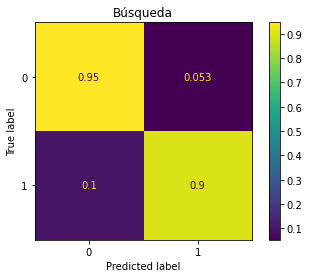

In [ ]:
print('Accuracy test búsqueda = '+str(accuracy_score(y_test, clf_sm.predict(X_test_n))))

disp = plot_confusion_matrix(clf_sm, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

Balanced Accuracy test búsqueda = 0.9235195795646551


Text(0.5, 1.0, 'Búsqueda')

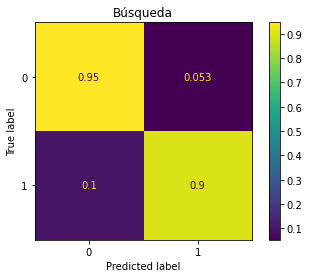

In [ ]:
print('Balanced Accuracy test búsqueda = '+str(balanced_accuracy_score(y_test, clf_sm.predict(X_test_n))))

disp = plot_confusion_matrix(clf_sm, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

In [ ]:
print(classification_report(y_test, y_predict1))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    828659
           1       0.05      0.90      0.09      2464

    accuracy                           0.95    831123
   macro avg       0.52      0.92      0.53    831123
weighted avg       1.00      0.95      0.97    831123



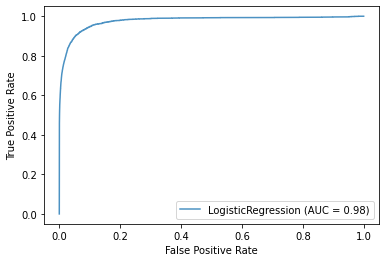

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(clf_sm, X_test_n, y_test, ax=ax, alpha=0.8)
plt.show()

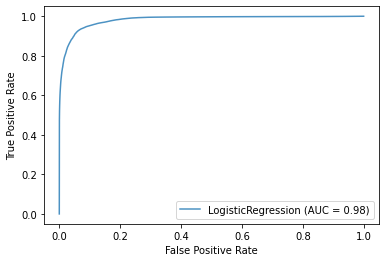

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(clf_sm, X_train_SMOTE, y_train_SMOTE, ax=ax, alpha=0.8)
plt.show()

**Modelo 2: Smote con RandomForestClassifier**

In [ ]:
st = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

In [ ]:
B=[5, 10, 15]
grid_values1_sm = {'n_estimators':B, 'max_depth':[3, 4]}

clf1_sm = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_clf1_sm = GridSearchCV(estimator=clf1_sm, param_grid = grid_values1_sm, cv=st ,return_train_score=True)
grid_clf1_sm.fit(X_train_SMOTE, y_train_SMOTE)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
          

In [ ]:
y_predict2 = grid_clf1_sm.predict(X_test_n)
print(accuracy_score(y_test,y_predict2))

0.9860249325310454


In [ ]:
print(confusion_matrix(y_test, y_predict2))

[[818189  10470]
 [  1145   1319]]


Accuracy test búsqueda = 0.9860249325310454


Text(0.5, 1.0, 'Búsqueda')

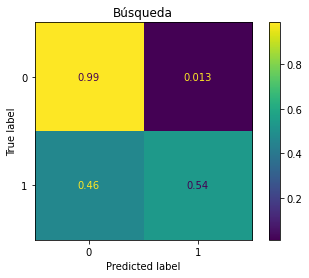

In [ ]:
print('Accuracy test búsqueda = '+str(accuracy_score(y_test, grid_clf1_sm.predict(X_test_n))))

disp = plot_confusion_matrix(grid_clf1_sm, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

Balanced Accuracy test búsqueda = 0.7613367850185521


Text(0.5, 1.0, 'Búsqueda')

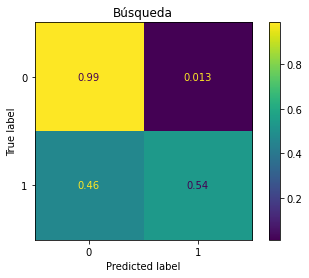

In [ ]:
print('Balanced Accuracy test búsqueda = '+str(balanced_accuracy_score(y_test, grid_clf1_sm.predict(X_test_n))))

disp = plot_confusion_matrix(grid_clf1_sm, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

In [ ]:
print(classification_report(y_test, y_predict2))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    828659
           1       0.11      0.54      0.19      2464

    accuracy                           0.99    831123
   macro avg       0.56      0.76      0.59    831123
weighted avg       1.00      0.99      0.99    831123



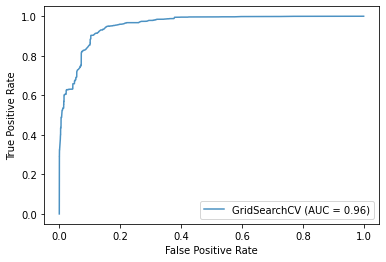

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(grid_clf1_sm, X_test_n, y_test, ax=ax, alpha=0.8)
plt.show()

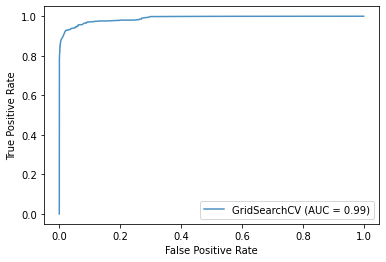

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(grid_clf1_sm, X_train_SMOTE, y_train_SMOTE, ax=ax, alpha=0.8)
plt.show()

**Modelo 3: Smote con Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB

grid_values2 = {'var_smoothing': [1e-2, 1e-4, 1e-6, 1e-10, 1e-15]}

In [ ]:
grid_clf2_sm = GridSearchCV(GaussianNB(), cv=skf, param_grid=grid_values2)
grid_clf2_sm.fit(X_train_SMOTE, y_train_SMOTE)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': [0.01, 0.0001, 1e-06, 1e-10, 1e-15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
model2_sm = grid_clf2_sm.best_estimator_
model2_sm

GaussianNB(priors=None, var_smoothing=1e-10)

In [ ]:
 pred2_sm = model2_sm.predict(X_test_n)
 print(confusion_matrix(y_test, pred2_sm))

[[809442  19217]
 [  1256   1208]]


In [ ]:
scores10 = cross_val_score(model2_sm, X_train_SMOTE, y_train_SMOTE, cv=skf, scoring="accuracy")
scores10

array([0.74363181, 0.74664107, 0.74491398])

In [ ]:
scores11 = cross_val_score(model2_sm, X_train_SMOTE, y_train_SMOTE, cv=skf, scoring="recall")
scores11

array([0.51072594, 0.51763735, 0.51261419])

Accuracy test búsqueda = 0.9753670635994913


Text(0.5, 1.0, 'Búsqueda')

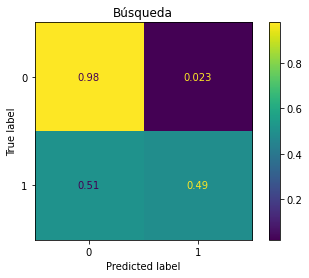

In [ ]:
print('Accuracy test búsqueda = '+str(accuracy_score(y_test,model2_sm.predict(X_test_n))))

disp = plot_confusion_matrix(model2_sm, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

Balanced Accuracy test búsqueda = 0.7335346301095482


Text(0.5, 1.0, 'Búsqueda')

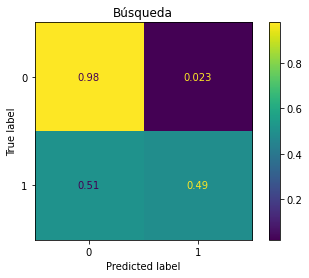

In [ ]:
print('Balanced Accuracy test búsqueda = '+str(balanced_accuracy_score(y_test,model2_sm.predict(X_test_n))))

disp = plot_confusion_matrix(model2_sm, X_test_n, y_test,normalize='true')
disp.ax_.set_title('Búsqueda')

In [ ]:
print(classification_report(y_test, pred2_sm))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    828659
           1       0.06      0.49      0.11      2464

    accuracy                           0.98    831123
   macro avg       0.53      0.73      0.55    831123
weighted avg       1.00      0.98      0.98    831123



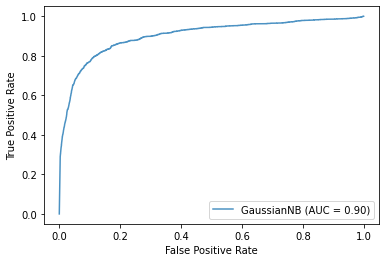

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(model2_sm, X_test_n, y_test, ax=ax, alpha=0.8)
plt.show()

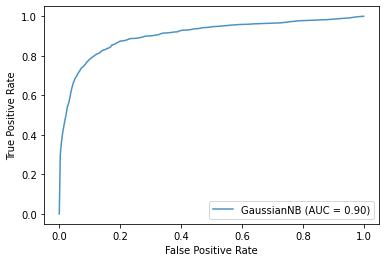

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(model2_sm, X_train_SMOTE, y_train_SMOTE, ax=ax, alpha=0.8)
plt.show()

**Modelo 4: Smote con Red Neuronal**

Ahora implementamos un red neuronal usando keras

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import tensorflow as tf
keras.backend.clear_session()

modelB= keras.models.Sequential()
modelB.add(keras.layers.Dense(25, input_dim=X_train_SMOTE.shape[1], activation='relu', kernel_initializer='he_uniform'))
modelB.add(keras.layers.Dropout(0.4))
modelB.add(keras.layers.Dense(10, input_dim=X_train_SMOTE.shape[1], activation='relu', kernel_initializer='he_uniform'))
modelB.add(keras.layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
modelB.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=[tf.keras.metrics.AUC(curve='ROC')])


In [ ]:
historyB = modelB.fit(X_train_SMOTE, y_train_SMOTE, validation_data=(scaler.fit_transform(X_test), y_test), epochs=10)

Epoch 1/10
120847/120847 [==============================] - 192s 2ms/step - loss: 0.1043 - auc: 0.9915 - val_loss: 0.0402 - val_auc: 0.9964
Epoch 2/10
120847/120847 [==============================] - 194s 2ms/step - loss: 0.0589 - auc: 0.9965 - val_loss: 0.0611 - val_auc: 0.9961
Epoch 3/10
120847/120847 [==============================] - 189s 2ms/step - loss: 0.0740 - auc: 0.9957 - val_loss: 0.0276 - val_auc: 0.9959
Epoch 4/10
120847/120847 [==============================] - 192s 2ms/step - loss: 0.0844 - auc: 0.9932 - val_loss: 0.1201 - val_auc: 0.9837
Epoch 5/10
120847/120847 [==============================] - 191s 2ms/step - loss: 0.0858 - auc: 0.9932 - val_loss: 0.0284 - val_auc: 0.9957
Epoch 6/10
120847/120847 [==============================] - 190s 2ms/step - loss: 0.0607 - auc: 0.9962 - val_loss: 0.0141 - val_auc: 0.9955
Epoch 7/10
120847/120847 [==============================] - 190s 2ms/step - loss: 0.0624 - auc: 0.9960 - val_loss: 0.0747 - val_auc: 0.9848
Epoch 8/10
120847/12

In [ ]:
from sklearn.metrics import confusion_matrix
pred5=modelB.predict_classes(scaler.fit_transform(X_test_n))
Cm = confusion_matrix(y_test,pred5)
Cm

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[824612,   4047],
       [   323,   2141]])

In [ ]:
print(classification_report(y_test, pred5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.35      0.87      0.49      2464

    accuracy                           0.99    831123
   macro avg       0.67      0.93      0.75    831123
weighted avg       1.00      0.99      1.00    831123



Evaluamos el modelo

Train: 0.997, Test: 0.995


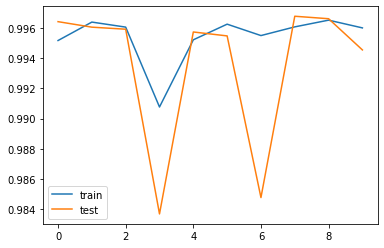

In [ ]:
_, train_acc = modelB.evaluate(X_train_SMOTE, y_train_SMOTE, verbose=0)
_, test_acc = modelB.evaluate(scaler.fit_transform(X_test_n), y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

plt.plot(historyB.history['auc'], label='train')
plt.plot(historyB.history['val_auc'], label='test')
plt.legend()
plt.show()

# **Conclusiones:**

Se buscó implementar un modelo analítico que tuviera un buen ajuste (buena precisión) a la hora de detectar transacciones fraudulentas realizadas a través del sistema de billetera móvil, cuyo costo operacional y tiempo de identificación fuera mínimo.

Partiendo del hecho que se cuenta con un dataset altamente desbalanceado y que existe gran variedad de técnicas para afrontar dicho problema, con sus pro y sus contras, se decide inicialmente aplicar varios modelos sin generar datos sintéticos y luego se aplicó la técnica de sobremuestreo de minorías (SMOTE). Adicional se aplican las métricas de exactitud, precisión y sensibilidad, dando mayor credibilidad a las dos últimas, ya que para este tipo de datos resulta poco válida la métrica de exactitud, porque puede generar datos engañosos por dicho desbalanceo, lo cual se evidencia en el resultado de los modelos implementados.

La comparación de eficiencia de los modelos con y sin datos sintéticos no reportó diferencias significativas en sus resultados, pero si en el costo computacional y tiempo de espera en las estimaciones de los parámetros ya que fueron bastante altos en comparación al tiempo y validaciones sin sobremuestreo.

En cuanto a los resultados, el mejor se obtiene mediante el uso de la Regresión Logística, sin tener en cuenta el sobremuestreo. 
Aunque la totalidad de los modelos obtuvieron resultados similares con diferentes métricas, se evidencia un bajo desempeño en los modelos Naive Bayes y Random Forest.

Es importante tener en cuenta que la base con la que se trabaja tiene una gran cantidad de transacciones, que al implementar técnicas o modelos analíticos como una máquina de soporte vectorial (SVM) o realizar técnicas de sobremuestreo implican un costo computacional muy grande para lograr detectar de manera rápida aquellas transacciones que puedan ser fraude.

